In [100]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from scipy.stats import multivariate_normal
try:
    from sklearn.linear_model import Ridge
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.linear_model import Ridge
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

In [101]:
latexify(width_scale_factor=1, fig_height=4)

/home/anand/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Generate Data

In [102]:
polydeg = 2 #Degree of design matrix
alph = 0.001 #Alpha of ridge regression
NFuncSamples = 10 #Number of sample coefficients to draw and use for prediction
vis = 0.5 #Transparency of plotted lines - in case we wish to plot a bunch.

# np.random.seed(0)
key = jax.random.PRNGKey(1)
xtrain = jnp.array([-3, -2, 0, 2, 3])
xtest = jnp.linspace(-7,7,141)
sigma2 = 25

def fun(x): return 10 + x + x**2

ytrain = fun(xtrain) + jax.random.normal(key=key,shape=[xtrain.shape[0]])*jnp.sqrt(sigma2)
ytest = fun(xtest) +  jax.random.normal(key=key,shape=[xtest.shape[0]])*jnp.sqrt(sigma2)

def shp(x): return jnp.asarray(x).reshape(-1,1)

xtrain = shp(xtrain)
xtest = shp(xtest)
ytrain = shp(ytrain)
ytest = shp(ytest)


In [103]:
def polyBasis(x, deg):
    #Expands a vector to a polynomial design matrix: from a constant to the deg-power
    return(jnp.column_stack([x**deg for deg in range(0, deg+1)]))

def MakePlot(ypreds, SaveN, Title, lowerb = None, upperb = None):
    #Function for creating and saving plots
    if not is_latexify_enabled():
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots()
    ax.scatter(xtrain, ytrain, s=140, facecolors='none', edgecolors='r', label='training data')
    #plt.ylim([-10,80])    
    #plt.xlim([-8,8])
    Errlogi = lowerb is not None or upperb is not None #Determines where we will be plotting error bars as well
    if Errlogi:
        errspacing = [int(round(s)) for s in jnp.linspace(0,xtest.shape[0]-1,30)]
        errspacing_reshaped = jnp.reshape(jnp.array(errspacing),(1,len(errspacing)))
        yerr = [list(lowerb[jnp.array(errspacing)]),list(upperb[jnp.array(errspacing)])]
        ax.errorbar(xtest[errspacing_reshaped][0,:,:], ypreds[jnp.array(errspacing),0], yerr=yerr)
        ax.fill_between(xtest[:,0], ypreds[:,0] + lowerb, ypreds[:,0] - upperb, alpha = 0.3, label="uncertainity")

    for j in range(ypreds.shape[1]):
        ax.plot(xtest,ypreds[:,j],color='k', linewidth=2.0, label='prediction', alpha = vis)
    if Errlogi:
        plt.legend(loc=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(Title)
#     pml.savefig(SaveN +'.pdf')



In [104]:
xtrainp = polyBasis(xtrain,polydeg)
xtestp = polyBasis(xtest,polydeg)

#Declare and fit linear regression model
LinR = Ridge(alpha=alph,fit_intercept=False)
LinR.fit(xtrainp,ytrain)

#Determine coefficient distribution
wmle = LinR.coef_.reshape(-1,) #Mean of coefficients
wcov = sigma2 * jnp.linalg.inv(jnp.diag(jnp.array([alph]*(polydeg+1))) + xtrainp.T.dot(xtrainp)) #Covariance of coefficients
CoefPostDist = multivariate_normal(mean = wmle, cov = wcov)
Samples = CoefPostDist.rvs(NFuncSamples)
 
#Sample predictions according to samples of coefficients
SamplePreds = xtestp.dot(Samples.T)

ypredmle = LinR.predict(xtestp) #MLE prediction
noisemle = jnp.var(ytrain - LinR.predict(xtrainp),ddof=(polydeg + 1)) #MLE noise estimation

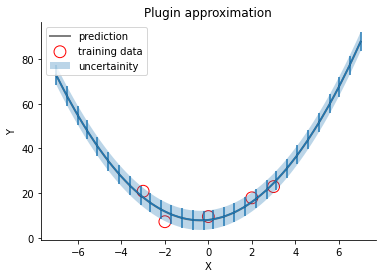

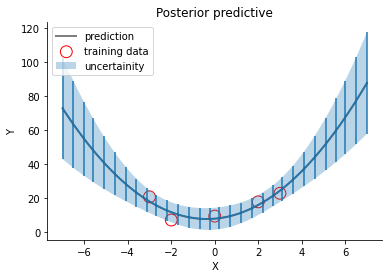

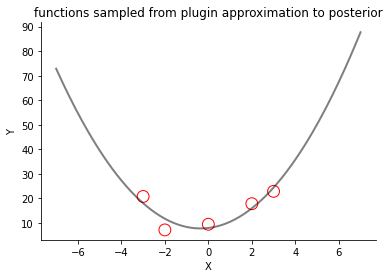

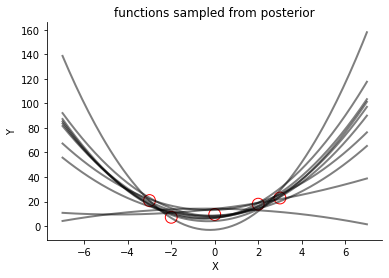

In [105]:
#plot a
noisevec = jnp.array([jnp.sqrt(noisemle)] * ypredmle.shape[0])
MakePlot(ypredmle, 'linregPostPredPlugin', 'Plugin approximation', noisevec, noisevec)

#plot b
postnoise = jnp.array([jnp.sqrt(sigma2 + xtestp[i,:].T.dot(wcov.dot(xtestp[i,:]))) for i in range(xtestp.shape[0])])
MakePlot(ypredmle, 'linregPostPredBayes', 'Posterior predictive', postnoise, postnoise)

#plot c
MakePlot(ypredmle, 'linregPostPredSamplesPlugin', 'functions sampled from plugin approximation to posterior')

#plot d
MakePlot(SamplePreds, 'linregPostPredSamples', 'functions sampled from posterior')
plt.show()